# About

Testing SVR Regression on Retrieval Task.

In [55]:
import numpy as np
import pandas as pd
import torch, torch.nn.functional as F
import os
import gc 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from IPython.core.display import display, HTML
from sklearn.manifold import TSNE
from heapq import nlargest
from io import StringIO
from tqdm.auto import tqdm
from transformers import AutoModel,AutoTokenizer
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from cuml.svm import SVR as cumlSVR
from cuml.preprocessing import StandardScaler as cumlStandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

/tmp/ipykernel_394318/1929859252.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [56]:
pd.set_option('display.max_colwidth', None)  # None means unlimited width

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(device)
print(available_gpus)

cuda
[<torch.cuda.device object at 0x7f928a6cdab0>, <torch.cuda.device object at 0x7f928acacf70>]


In [57]:
class Config:
    GERDALIR_PATH = './data/GerDaLIR/'
    EMBEDDINGS_DIRECTORY = './data/embeddings/'
    REMOVE_STOPWORDS = False
    EPXLODE_SENTENCES = True
    USE_TFIDF = False
    CHUNK_QUERIES = True

# Read Data

In [58]:
def read_tsv(file_path):
    data = []
    with open(file_path, 'r', encoding='utf8') as file:
        for line in file:
            columns = line.strip().split('\t')
            # Concatenate columns from index 1 onwards (since we have some broken rows)
            concatenated_value = ''.join(columns[1:])
            data.append((columns[0], concatenated_value))

    df = pd.DataFrame(data, columns=['id', 'value'])
    return df

In [59]:
collection = read_tsv(Config.GERDALIR_PATH + 'collection/collection.tsv').head(100000)
collection.rename(columns={'id': 'd_id', 'value':'passage'}, inplace=True)
collection.reset_index(inplace=True)

rels = read_tsv(Config.GERDALIR_PATH + 'qrels/qrels.train.tsv')
rels.rename(columns={'id': 'q_id', 'value': 'd_id'}, inplace=True)
rels = rels[rels['d_id'].isin(collection['d_id'].values)] # This can be deleted once we work with all
rels.reset_index(inplace=True)

queries = read_tsv(Config.GERDALIR_PATH + 'queries/queries.train.tsv')
queries.rename(columns={'id': 'q_id', 'value': 'query'}, inplace=True)
queries = queries[queries['q_id'].isin(rels['q_id'].values)] # This can be deleted once we work with all
queries.reset_index(inplace=True)

In [60]:
display(queries.head(2))
display(len(queries))

display(collection.head(2))
display(len(collection))

display(rels.head(2))
display(len(rels))

,index,q_id,query
0,3,5,"Die streitgegenständliche Satzung gibt nicht die Rechtsvorschriften an, welche zum Erlass der Satzung berechtigen, [REF] . Dies ist aber insbesondere bei belastenden Eingriffen wie der Abgabenerhebung erforderlich . Die Exekutive muss durch Angabe ihrer Ermächtigungsgrundlage sich selbst des ihr aufgegebenen Normsetzungsprogramms vergewissern und hat sich auf dieses zu beschränken. Es kommt daher nicht nur darauf an, ob sie sich überhaupt im Rahmen der delegierten Rechtssetzungsgewalt bewegt, vielmehr muss sich die in Anspruch genommene Rechtssetzungsbefugnis gerade aus den von ihr selbst angeführten Vorschriften ergeben. Außerdem dient das Zitiergebot der Offenlegung des Ermächtigungsrahmens gegenüber dem Adressaten der Satzung. Das soll ihm die Kontrolle ermöglichen, ob die Satzung mit dem ermächtigenden Gesetz übereinstimmt ."
1,4,6,"Insofern gehört zur zutreffenden Angabe der zum Erlass der Satzung berechtigenden Rechtsvorschriften im Sinne des [REF] nicht nur die genaue Angabe der zur Erhebung der Abgabe berechtigenden Norm des Kommunalabgabengesetzes, sondern bei kommunalen Abgaben auch deren nach dieser Norm namentlich zutreffende Bezeichnung . Berechtigt eine Norm zur Erhebung unterschiedlicher Abgaben wie zur Erhebung der Kurabgabe und der Tourismusabgabe , so gehört zur genauen Bezeichnung der zum Erlass der Satzung berechtigenden Rechtsvorschriften im Sinne des [REF] auch die Nennung des zutreffenden Absatzes bzw. der zutreffenden Absätze der Norm, gegebenenfalls einschließlich des dazugehörenden Satzes oder der dazugehörenden Sätze, die zur Erhebung der gewählten Abgabe berechtigen"


606

,index,d_id,passage
0,0,1,Tenor Der Antrag der Klägerin auf Zulassung der Berufung gegen das Urteil des Verwaltungsgerichts Gelsenkirchen vom [DATE] wird abgelehnt. Die Klägerin trägt die Kosten des Zulassungsverfahrens. Der Streitwert wird auch für das Zulassungsverfahren auf 0 Euro festgesetzt. Gründe:
1,1,1,"Das Zulassungsvorbringen der Klägerin begründet keine ernstlichen Zweifel an der Richtigkeit des angefochtenen Urteils . Zweifel in diesem Sinn sind anzunehmen, wenn ein einzelner tragender Rechtssatz oder eine einzelne erhebliche Tatsachenfeststellung des Verwaltungsgerichts mit schlüssigen Gegenargumenten in Frage gestellt werden."


100000

,index,q_id,d_id
0,5,5,2364
1,6,6,2364


663

# Postprocess

In [61]:
def chunk_string_with_overlap(s, k, overlap):
    if k <= 0:
        raise ValueError("Chunk length must be greater than 0")
    if overlap < 0:
        raise ValueError("Overlap must be non-negative")
    if overlap >= k:
        raise ValueError("Overlap must be less than chunk length")
    
    chunks = []
    for i in range(0, len(s), k - overlap):
        chunk = s[i:i + k]
        chunks.append(chunk)
        if len(chunk) < k:
            break
    
    return chunks

Average length of queries:

In [62]:
print(queries['query'].apply(lambda x: len(x.split())).mean())
print(queries['query'].apply(lambda x: len(x)).mean())

131.1204620462046
1004.4438943894389


In [63]:
if(Config.CHUNK_QUERIES):
    queries['query'] = queries['query'].apply(lambda q: chunk_string_with_overlap(q, 275, 15))
    queries = queries.explode('query').reset_index(drop=True)
    display(queries.head(10))
    print(len(queries))

,index,q_id,query
0,3,5,"Die streitgegenständliche Satzung gibt nicht die Rechtsvorschriften an, welche zum Erlass der Satzung berechtigen, [REF] . Dies ist aber insbesondere bei belastenden Eingriffen wie der Abgabenerhebung erforderlich . Die Exekutive muss durch Angabe ihrer Ermächtigungsgrundlag"
1,3,5,"tigungsgrundlage sich selbst des ihr aufgegebenen Normsetzungsprogramms vergewissern und hat sich auf dieses zu beschränken. Es kommt daher nicht nur darauf an, ob sie sich überhaupt im Rahmen der delegierten Rechtssetzungsgewalt bewegt, vielmehr muss sich die in Anspruch ge"
2,3,5,"in Anspruch genommene Rechtssetzungsbefugnis gerade aus den von ihr selbst angeführten Vorschriften ergeben. Außerdem dient das Zitiergebot der Offenlegung des Ermächtigungsrahmens gegenüber dem Adressaten der Satzung. Das soll ihm die Kontrolle ermöglichen, ob die Satzung"
3,3,5,ob die Satzung mit dem ermächtigenden Gesetz übereinstimmt .
4,4,6,"Insofern gehört zur zutreffenden Angabe der zum Erlass der Satzung berechtigenden Rechtsvorschriften im Sinne des [REF] nicht nur die genaue Angabe der zur Erhebung der Abgabe berechtigenden Norm des Kommunalabgabengesetzes, sondern bei kommunalen Abgaben auch deren nach die"
5,4,6,"deren nach dieser Norm namentlich zutreffende Bezeichnung . Berechtigt eine Norm zur Erhebung unterschiedlicher Abgaben wie zur Erhebung der Kurabgabe und der Tourismusabgabe , so gehört zur genauen Bezeichnung der zum Erlass der Satzung berechtigenden Rechtsvorschriften im"
6,4,6,"vorschriften im Sinne des [REF] auch die Nennung des zutreffenden Absatzes bzw. der zutreffenden Absätze der Norm, gegebenenfalls einschließlich des dazugehörenden Satzes oder der dazugehörenden Sätze, die zur Erhebung der gewählten Abgabe berechtigen"
7,5,7,"[REF] , juris, Rn. 0). Bei einer Übertragung einer gemeindlichen Selbstverwaltungsaufgabe sind zudem die Rechtsvorschriften zu nennen, die dazu berechtigen die zur Gebührenerhebung berechtigende Aufgabe und die dazugehörige Satzungsbefugnis zu übertragen ."
8,6,9,"Aus [REF] ergibt sich, dass u.a. Ämter in Erfüllung ihrer Selbstverwaltungsaufgaben um eine solche handelt es sich hier, da sich der Charakter der Aufgabe durch den Übergang nicht ändert kommunale Abgaben erheben können. Die Vorschrift ist auch absatzgetreu zu zitieren, da d"
9,6,9,"zitieren, da die Norm hinsichtlich der zur Abgabenerhebung berechtigten Körperschaft des öffentlichen Rechts in den Absätzen 0 und 0 differenziert ."


2608


# Embeddings

In [64]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [65]:
class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length, text_col):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.max = max_length

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.loc[idx, self.text_col]
        tokens = self.tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=self.max,
                return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

In [66]:
class EmbedderContainer:

    def __init__(self, model_name, max_length, batch_size, device):
        self.device = device
        self.model_name = model_name
        self.__model_path = model_name
        self.__max_length = max_length
        self.__batch_size = batch_size

    def init_model(self):
        self.__model = AutoModel.from_pretrained(self.__model_path, trust_remote_code=True).to(self.device)  #force_download=True
        self.__model.eval()
        self.__tokenizer = AutoTokenizer.from_pretrained(self.__model_path, trust_remote_code=True)  #force_download=True

    def init_embed_dataset(self, df, text_col):
        self.__dataset = EmbedDataset(df, self.__tokenizer, self.__max_length, text_col)
        self.__embed_dataloader = torch.utils.data.DataLoader(self.__dataset,
                                batch_size=self.__batch_size,
                                shuffle=False)
        return self.__embed_dataloader

    def embed(self, input_ids, attention_mask):
        return self.__model(input_ids=input_ids, attention_mask=attention_mask)

    def dispose(self):
        if hasattr(self, '__dataset'):
            del self.__dataset
        if hasattr(self, '__embed_dataloader'):
            del self.__embed_dataloader
        if hasattr(self, '__model'):
            del self.__model
        if hasattr(self, '__tokenizer'):
            del self.__tokenizer
        gc.collect()
        torch.cuda.empty_cache()
    

In [67]:
def get_embeddings(embedding_container, compute_collection=True, compute_queries=False):

    global collection, queries
    embedding_container.init_model()

    # COMPUTE COLLECTION EMBEDDINGS
    all_collection_embeddings = []
    if compute_collection:
        # Create dataset for collection
        embed_dataloader_tr = embedding_container.init_embed_dataset(collection, 'passage')
        for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
            input_ids = batch["input_ids"].to(embedding_container.device)
            attention_mask = batch["attention_mask"].to(embedding_container.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = embedding_container.embed(input_ids, attention_mask)

            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_collection_embeddings.extend(sentence_embeddings)
    all_collection_embeddings = np.array(all_collection_embeddings)

    # COMPUTE QUERY EMBEDDINGS
    all_query_embeddings = []
    if compute_queries:
        # Create dataset for query
        embed_dataloader_te = embedding_container.init_embed_dataset(queries, 'query')
        for batch in embed_dataloader_te:
            input_ids = batch["input_ids"].to(embedding_container.device)
            attention_mask = batch["attention_mask"].to(embedding_container.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = embedding_container.embed(input_ids, attention_mask)
            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_query_embeddings.extend(sentence_embeddings)
    all_query_embeddings = np.array(all_query_embeddings)

    # DISPOSE
    if 'model_output' in locals():
        del model_output
    if 'sentence_embeddings' in locals():
        del sentence_embeddings
    if 'input_ids' in locals():
        del input_ids
    if 'attention_mask' in locals():
        del attention_mask
    embedding_container.dispose()

    # RETURN EMBEDDINGS
    return all_collection_embeddings, all_query_embeddings

### Possible Embedding Models

In [68]:
DEVICE = "cuda:1" # We want to extract embeddings on the second GPU.

container = [
    #EmbedderContainer('microsoft/deberta-base', 1024, 32, DEVICE),
    #EmbedderContainer('microsoft/deberta-large', 1024, 8, DEVICE),
    #EmbedderContainer('microsoft/deberta-v3-large', 1024, 8, DEVICE),
    EmbedderContainer('allenai/longformer-base-4096', 1024, 32, DEVICE),
    #EmbedderContainer('LennartKeller/longformer-gottbert-base-8192-aw512', 1024, 32, DEVICE),
    #EmbedderContainer('allenai/longformer-large-4096', 1024, 8, DEVICE),
    #EmbedderContainer('google/bigbird-roberta-base', 1024, 32, DEVICE),
    #EmbedderContainer('google/bigbird-roberta-large', 1024, 8, DEVICE),

    # Sentence Transformers fine-tuned for sentence embeddings:
    # EmbedderContainer('sentence-transformers/all-distilroberta-v1', 512, 32, DEVICE), # https://huggingface.co/sentence-transformers/all-distilroberta-v1
    # EmbedderContainer('sentence-transformers/msmarco-distilbert-base-v4', 512, 32, DEVICE), # https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v4
    #EmbedderContainer('sentence-transformers/all-MiniLM-L6-v2', 384, 64, DEVICE), # https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
]

### Generate Embeddings

In [69]:
all_collection_embeds = []
all_query_embeds = []

for embedding_container in container:
    name = (Config.EMBEDDINGS_DIRECTORY + 
            'collection_' + 
            embedding_container.model_name.replace("/", "_") + 
            ".npy")
    
    if os.path.exists(name):
        print(f"Loading embeddings for {name}")
        _, query_embed = get_embeddings(embedding_container, compute_collection=False, compute_queries=True)
        collection_embed = np.load(name)
    else:
        print(f"Computing embeddings for {name}") 
        collection_embed, query_embed = get_embeddings(embedding_container, compute_collection=True, compute_queries=True)
        np.save(name, collection_embed)
    all_collection_embeds.append(collection_embed)
    all_query_embeds.append(query_embed)

del collection_embed, query_embed

Loading embeddings for ./data/embeddings/collection_allenai_longformer-base-4096.npy


/home/staff_homes/kboenisc/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [70]:
all_collection_embeds = np.concatenate(all_collection_embeds,axis=1)
all_query_embeds = np.concatenate(all_query_embeds,axis=1)

In [71]:
print(all_collection_embeds.shape)
print(all_query_embeds.shape)

(100000, 768)
(2608, 768)


In [72]:
gc.collect()

11

# Training

In [97]:
features = []
labels = []

subsampling_top_k = 1000

query_idx_lookup = {qid: idx for idx, qid in enumerate(queries['q_id'])}
passage_idx_lookup = {pid: idx for idx, pid in enumerate(collection['d_id'])}

In [98]:
print(passage_idx_lookup)

{'1': 3, '2': 18, '3': 44, '4': 53, '5': 55, '6': 67, '7': 72, '8': 77, '9': 82, '10': 107, '11': 113, '12': 149, '13': 174, '14': 191, '15': 237, '16': 241, '17': 288, '18': 294, '19': 302, '20': 326, '21': 345, '22': 379, '23': 442, '24': 479, '25': 484, '26': 496, '27': 520, '28': 553, '29': 568, '30': 573, '31': 578, '32': 653, '33': 657, '34': 661, '35': 678, '36': 709, '37': 718, '38': 737, '39': 798, '40': 814, '41': 841, '42': 853, '43': 882, '44': 907, '45': 924, '46': 930, '47': 946, '48': 964, '49': 970, '50': 974, '51': 983, '52': 991, '53': 1005, '54': 1010, '55': 1040, '56': 1050, '57': 1055, '58': 1069, '59': 1084, '60': 1099, '61': 1106, '62': 1123, '63': 1126, '64': 1139, '65': 1157, '66': 1162, '67': 1223, '68': 1285, '69': 1328, '70': 1347, '71': 1400, '72': 1412, '73': 1420, '74': 1454, '75': 1508, '76': 1521, '77': 1550, '78': 1574, '79': 1590, '80': 1607, '81': 1608, '82': 1635, '83': 1663, '84': 1703, '85': 1726, '86': 1740, '87': 1756, '88': 1772, '89': 1788, '9

In [99]:
def query_fits_passage(q_idx, c_idx):
    '''Does the given collection index fit to a given query index?'''
    q_id = queries.iloc[q_idx]['q_id']
    d_id = collection.iloc[c_idx]['d_id']
    return len(rels[(rels['q_id'] == q_id) & (rels['d_id'] == d_id)].values) > 0

In [100]:
for query_id in tqdm(queries.head(10000)['q_id'], desc="Processing queries"):
    query_idx = query_idx_lookup[query_id]
    query_embed = all_query_embeds[query_idx]

    # Positive samples
    positive_indices = set()
    rels_for_query = rels[rels['q_id'] == query_id]
    for passage_id in rels_for_query['d_id']:
        if passage_id in passage_idx_lookup:
            passage_idx = passage_idx_lookup[passage_id]
            passage_embed = all_collection_embeds[passage_idx]
            feature = np.concatenate((query_embed, passage_embed))
            features.append(feature)
            labels.append(1)
            positive_indices.add(passage_idx)
    
    # Compute cosine similarity to get the top k nearest negative subsamples 
    cos_sim = 1 - cdist([query_embed], all_collection_embeds, metric='cosine').flatten()
    
    # Use a heap to find the top k nearest negative indices
    top_k_indices = nlargest(subsampling_top_k + len(positive_indices), range(len(cos_sim)), key=lambda x: cos_sim[x])
    negative_indices = top_k_indices[:subsampling_top_k]
    
    for passage_idx in negative_indices:
        passage_embed = all_collection_embeds[passage_idx]
        feature = np.concatenate((query_embed, passage_embed))
        features.append(feature)
        labels.append(0)

Processing queries: 100%|███████████████████████████████████████████████████████████| 2608/2608 [09:00<00:00,  4.82it/s]


In [101]:
features = np.array(features)
labels = np.array(labels)

In [102]:
# Ensure there are no NaNs or infinities in the data
if np.any(np.isnan(features)) or np.any(np.isinf(features)):
    raise ValueError("Input data contains NaNs or infinite values")

In [103]:
print(features.shape)
print(labels.shape)
print(labels[:200])
print('Negative labels: ' + str(len(list(filter(lambda x: x == 0, labels)))))
print('Positive labels: ' + str(len(list(filter(lambda x: x > 0, labels)))))


(2610928, 1536)
(2610928,)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Negative labels: 2608000
Positive labels: 2928


In [104]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

In [105]:
print(len(X_train))
print(len(X_train))
print(len(y_train))
print(len(y_test))

2349835
2349835
2349835
261093


**Even with subsampling, we still have a class imbalance. Counter that:**

*Update*: Yikes, RAPIDS doesn't support passing the class_weights into the SVR yet.

In [106]:
# Compute class weights to handle imbalance
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

### Bagging

We have too many features and datapoints, which a single SVR can't handle on this machine. Instead, I'm going to:

- Train X different SVR using a portion of the rows
- Ensemble the SVRs
- In that way duplicate the bagging of Random Forest

In [107]:
# Helper function to create random subsets with overlap
def create_subsets(X, y, num_subsets, overlap_percentage):
    subsets = []
    subset_size = int((len(X) // num_subsets) * overlap_percentage)
    num_samples = len(X)
    
    for _ in range(num_subsets):
        subset_indices = np.random.choice(num_samples, size=subset_size, replace=True)
        X_subset = X[subset_indices]
        y_subset = y[subset_indices]
        subsets.append((X_subset, y_subset))
    
    return subsets

In [108]:
# Logging function to track progress
def log_progress(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    f1 = f1_score(y_val, y_pred_binary)
    accuracy = accuracy_score(y_val, y_pred_binary)
    
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')

In [109]:
gpu_scaler = cumlStandardScaler()

In [110]:
# Standardize the data
X_train_scaled = gpu_scaler.fit_transform(X_train)
X_test_scaled = gpu_scaler.transform(X_test)

In [111]:
num_subsets = 20
subsets = create_subsets(X_train_scaled, y_train, num_subsets, 1.6)

print(len(subsets))
print(len(subsets[0][0]))

20
187985


**Train SVR foreach subset**

In [112]:
svr_models = []
tqdm._instances.clear()

In [113]:
for i, (X_subset, y_subset) in enumerate(subsets):
    print(f'Training SVR model {i+1}/{num_subsets}')
    svr = cumlSVR(kernel='rbf')
    svr.fit(X_subset, y_subset)
    log_progress(svr, X_subset, y_subset)
    svr_models.append(svr)

Training SVR model 1/20
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 0.9799
  F1 Score: 0.9898
Training SVR model 2/20
  Accuracy: 0.9999
  Precision: 1.0000
  Recall: 0.9530
  F1 Score: 0.9759
Training SVR model 3/20
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 0.9650
  F1 Score: 0.9822
Training SVR model 4/20
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 0.9589
  F1 Score: 0.9790
Training SVR model 5/20
  Accuracy: 0.9999
  Precision: 1.0000
  Recall: 0.9476
  F1 Score: 0.9731
Training SVR model 6/20
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 0.9575
  F1 Score: 0.9783
Training SVR model 7/20
  Accuracy: 0.9999
  Precision: 1.0000
  Recall: 0.9312
  F1 Score: 0.9644
Training SVR model 8/20
  Accuracy: 0.9999
  Precision: 1.0000
  Recall: 0.9552
  F1 Score: 0.9771
Training SVR model 9/20
  Accuracy: 0.9999
  Precision: 1.0000
  Recall: 0.9459
  F1 Score: 0.9722
Training SVR model 10/20
  Accuracy: 0.9999
  Precision: 1.0000
  Recall: 0.9556
  F1 Score: 0.9773
Training 

In [114]:
# Save the ensembl
ensemble_filename = 'ensemble_svr_models.pkl'
with open(ensemble_filename, 'wb') as file:
    pickle.dump(svr_models, file)

print(f'Ensemble of SVR models saved to {ensemble_filename}')

Ensemble of SVR models saved to ensemble_svr_models.pkl


In [115]:
# Load the ensemble of models from the file
with open('ensemble_svr_models.pkl', 'rb') as file:
    loaded_svr_models = pickle.load(file)

print('Ensemble of SVR models loaded from file')

Ensemble of SVR models loaded from file


**Prediction method for the ensemble:**

In [151]:
def ensemble_predict(svr_models, X, threshold=0.5, proof=1):
    predictions = np.zeros((len(svr_models), len(X)))
    
    for i, svr in enumerate(svr_models):
        predictions[i] = svr.predict(X)
    
    # Count votes for each sample
    votes = np.sum(predictions > threshold, axis=0)
    
    # If more than half the models predict 1, return 1; otherwise, return 0
    final_predictions = (votes >= proof).astype(int)
    return final_predictions

In [152]:
# Make predictions on the test set using the loaded ensemble of SVR models
y_pred_binary = ensemble_predict(loaded_svr_models, X_test_scaled)

In [153]:
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)

print(f'Test set accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Test set accuracy: 1.0000
Precision: 0.9850
Recall: 0.9669
F1-score: 0.9759
Confusion Matrix:
[[260817      4]
 [     9    263]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    260821
           1       0.99      0.97      0.98       272

    accuracy                           1.00    261093
   macro avg       0.99      0.98      0.99    261093
weighted avg       1.00      1.00      1.00    261093



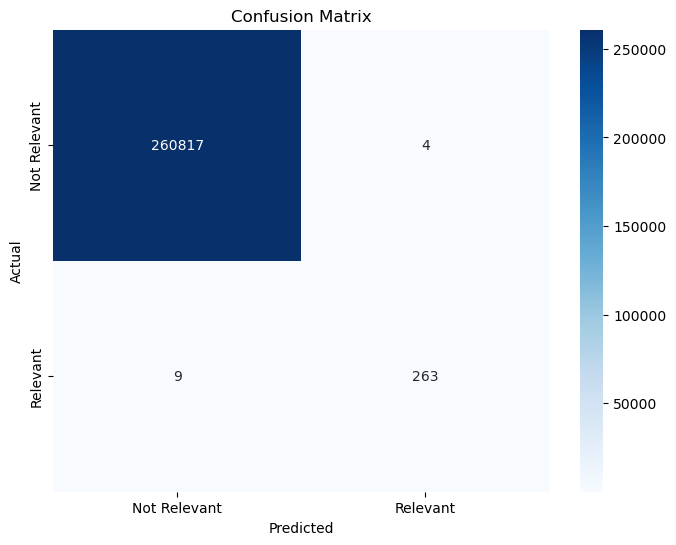

In [154]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Relevant', 'Relevant'], yticklabels=['Not Relevant', 'Relevant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

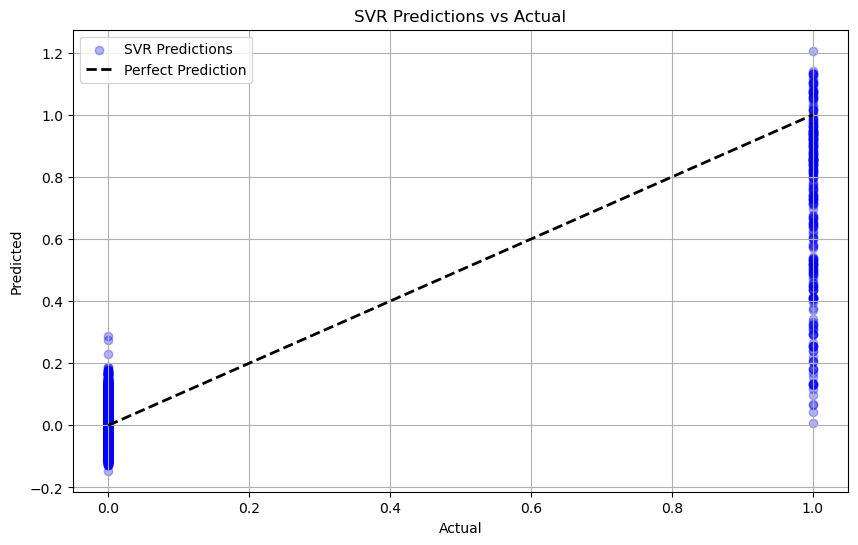

In [155]:
# Plotting SVR results (for regression)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.3, label='SVR Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.title('SVR Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()